# Analyzing Biodiversity and Conservation Status in National Parks.

## Introduction:

This is my first python project shared on Github. I will explore and perform data analysis on 2 datasets, sourced from the National Parks Service.

### Goals:
I will be looking to answer more questions as I begin exploring the data, but these questions will guide my intial exploration:

- What is the distribution of `conservation_status` for animals?  
- Are certain types of species more likely to be endangered?  
- Are the differences between species and their conservation status significant?  
- Which species were spotted the most at each park?

### Raw Data Files:

**species_info.csv** - contains data about different species and their conservation status.  
`category` - class of animal  
`scientific_name` - the scientific name of each species  
`common_name` - the common names of each species  
`conservation_status` - each species' current conservation status  

**observations.csv** - holds recorded sightings of different species at several national parks for the past 7 days.  
`scientific_name` - the scientific name of each species  
`park_name` - park where species were found  
`observations` - the number of times each species was observed at the park

## Load CSV Files: inspect first 10 rows.

During my review of the column names, I have decided not to name the DataFrame 'Observations' due to the identical column name. To avoid confusion, I will instead use 'tracking' as a synonym instead of observations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
species_df = pd.read_csv("~/Desktop/GitHub/BioDiversity-Project/Analysis/species_info.csv")
tracking_df = pd.read_csv("~/Desktop/GitHub/BioDiversity-Project/Analysis/observations.csv")

In [3]:
species_df.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [4]:
species_df.dtypes

category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object

In [5]:
tracking_df.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [6]:
tracking_df.dtypes

scientific_name    object
park_name          object
observations        int64
dtype: object

## Digging into the missing data.

I only see `NaN` values in  **species_df** for the column `conservation_status`- this will be something to look into a bit deeper as I begin to clean the data.  
*I also see that both df's contain the column `scientific_name`. This will be useful to act as a primary key, linking both tables by a shared relation if I choose to join both df's.*

**For now, though, I want to continue exploring the data while looking more into each column to see if any others contain NaN, or other possible issues that could be addressed with data cleaning.**

In [7]:
species_df_shape = species_df.columns, species_df.shape

species_df_shape

(Index(['category', 'scientific_name', 'common_names', 'conservation_status'], dtype='object'),
 (5824, 4))

In [8]:
tracking_df_shape = tracking_df.columns, tracking_df.shape

tracking_df_shape 

(Index(['scientific_name', 'park_name', 'observations'], dtype='object'),
 (23296, 3))

In [9]:
species_null = species_df.isnull().sum().sort_values(ascending=False)

species_null

conservation_status    5633
category                  0
scientific_name           0
common_names              0
dtype: int64

In [10]:
total_rows, total_col = species_df.shape
null_rows = species_null[0]
null_per = (null_rows/total_rows) *100

print(f"{null_per.round(3)}% of the rows in the conservation_status column are null.")

96.72% of the rows in the conservation_status column are null.


In [11]:
tracking_null = tracking_df.isnull().sum().sort_values(ascending=False)

tracking_null

scientific_name    0
park_name          0
observations       0
dtype: int64

**Diving deeper I see a majority of the rows in the `conservation_status` column have null values. I want to know if the missing values are: systematic, MAR, MCAR, or MNAR? Without much domain knowledge, I will look closer at the non-null values.**

In [12]:
conservation_types = species_df['conservation_status'].unique()

print("conservation_types:", conservation_types)
species_df['conservation_status'].value_counts()

conservation_types: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: conservation_status, dtype: int64

**`Conservation Status`** is an ordinal categorical variable with 4 categories: 
- Species of Concern, 
- Endangered, 
- Threatened, 
- In recovery. 
 
**It seems less surprising now, why there is a significant portion of null values (96.72%) - it is common for a species to not fit 1 of the 4 categories, which suggests that `NaN` values represent *no* conservation status,i.e. the species is not at risk.**

This insight allows me to make an important assumption: that `NaN` values are systematically missing due to the dataset only recording conservation status for species known to be at risk. However, it is crucial to remember that this is an assumption.

To perform a more comprehensive analysis, I will modify the null values to represent a 'Healthy' conservation status, indicating that the species is not considered at risk. This relabeling allows me to include these records in my analysis without the need to delete the rows entirely.

In [13]:
species_df['conservation_status'] = species_df['conservation_status'].fillna('Healthy').astype('category')
#con_status = species_df['conservation_status'].astype('category')
con_status = species_df['conservation_status']
labels = con_status.unique()
con_status_counts = con_status.value_counts()

con_status_counts

Healthy               5633
Species of Concern     161
Endangered              16
Threatened              10
In Recovery              4
Name: conservation_status, dtype: int64

In [14]:
prop = (con_status_counts/total_rows)*100

prop

Healthy               96.720467
Species of Concern     2.764423
Endangered             0.274725
Threatened             0.171703
In Recovery            0.068681
Name: conservation_status, dtype: float64

## Some insight into Q1. What is the distribution of `conservation_status` for animals?  

Before fully diving into Q1, I do want to quickly investigate the question with the current understanding so far established through the analysis up to this point. **Since I am not familiar with this dataset/domain of knowledge, I find it helpful to take extra time learning about the basic features, and how they relate.**

For example, it is more obvious looking at the proportions above to understand the distribution of species this dataset contains. It prepares me for further EDA, where I'd be interested in learning more about the distribution of `conservation_status` by national park - maybe some parks are home to more at-risk species than other parks!

### A visual of the `conservation_status` proportions:

In [15]:
legend_labels = [f'{label} - {prop:.1f}%' for label, prop in zip(labels, prop)]

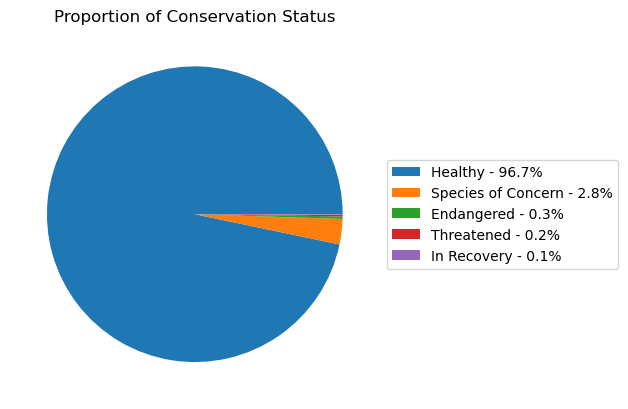

<Figure size 640x480 with 0 Axes>

In [16]:
plt.pie(con_status_counts)
plt.title('Proportion of Conservation Status')
plt.legend(legend_labels,bbox_to_anchor=(1, 0.5), loc='center left')

plt.show()
plt.clf()

It is hard to see any color except for **blue** and **orange**, indicating the other values are much less frequent.

With this additional understanding, I can think of 2 more questions I am interested in analyzing during EDA -- what is the proportion of `convservation_status` by:
- `national_park`?; to investigate if some parks are more difficult for a species to survive in.
- `category`?; to investigate if some categories of species have more difficulty surviving than others.

### Before performing in-depth EDA, I want to backup and finish the data cleaning.. I need to identify all duplicate rows.

In [17]:
s_dups = species_df.duplicated()
t_dups = tracking_df.duplicated()

s_dups.sum(), t_dups.sum()

(0, 15)

In [18]:
duplicates = tracking_df[tracking_df.duplicated(keep=False)]

duplicates.sort_values(by=['scientific_name'])

,scientific_name,park_name,observations
513,Arctium minus,Yosemite National Park,162
10674,Arctium minus,Yosemite National Park,162
4527,Botrychium virginianum,Yellowstone National Park,232
20294,Botrychium virginianum,Yellowstone National Park,232
19392,Cichorium intybus,Yellowstone National Park,266
14142,Cichorium intybus,Yellowstone National Park,266
7263,Echinochloa crus-galli,Great Smoky Mountains National Park,62
1454,Echinochloa crus-galli,Great Smoky Mountains National Park,62
1020,Eleocharis palustris,Great Smoky Mountains National Park,62
12381,Eleocharis palustris,Great Smoky Mountains National Park,62


The rows above are all duplicates. There seems to be no reason for including both records so i will now drop all duplicates, and check to ensure there are no further duplicates.

In [19]:
tracking_df = tracking_df.drop_duplicates()

tracking_df.duplicated().sum()

0

### At this point all null values have been handled, and all duplicates removed. The data is much cleaner!

Now, it would be beneficial to merge the two dataframes, enabling more comprehensive analysis, such as examining the relationship between `conservation_status` and `common_names`.

In [20]:
data = pd.merge(species_df, tracking_df, on='scientific_name')

In [21]:
check = data[data['scientific_name'] == 'Bos bison']
check

,category,scientific_name,common_names,conservation_status,park_name,observations
4,Mammal,Bos bison,"American Bison, Bison",Healthy,Yosemite National Park,128
5,Mammal,Bos bison,"American Bison, Bison",Healthy,Yellowstone National Park,269
6,Mammal,Bos bison,"American Bison, Bison",Healthy,Bryce National Park,68
7,Mammal,Bos bison,"American Bison, Bison",Healthy,Great Smoky Mountains National Park,77


In [22]:
check2 = data[(data.park_name == 'Bryce National Park') & (data.conservation_status == 'Endangered')]

check2

,category,scientific_name,common_names,conservation_status,park_name,observations
69,Mammal,Canis lupus,Gray Wolf,Endangered,Bryce National Park,27
70,Mammal,Canis lupus,Gray Wolf,Endangered,Bryce National Park,29
71,Mammal,Canis lupus,Gray Wolf,Endangered,Bryce National Park,74
93,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered,Bryce National Park,27
94,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered,Bryce National Park,29
95,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered,Bryce National Park,74
104,Mammal,Canis rufus,Red Wolf,Endangered,Bryce National Park,30
362,Mammal,Myotis grisescens,Gray Myotis,Endangered,Bryce National Park,27
416,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,Bryce National Park,27
626,Mammal,Glaucomys sabrinus coloratus,"Carolina Northern Flying Squirrel, Northern Fl...",Endangered,Bryce National Park,29


### We can now see how helpful it is to combine both dataframes into 1 dataframe. With this quick example, 'check'/'check2' show that: a) The American Bison is 'Healthy' in all parks, and b) 

Perhaps, some parks have higher concentrations of non-healthy species? And if so, do some category types (e.g. mammal, fish,etc.) have a high liklihood of becoming non-healthy?

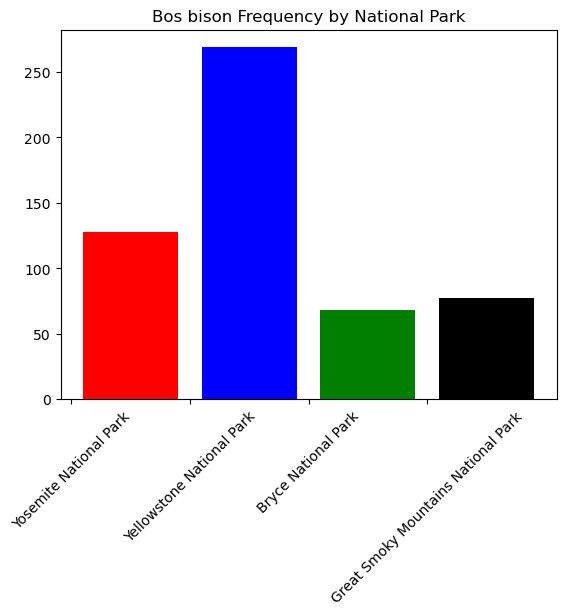

<Figure size 640x480 with 0 Axes>

In [23]:
plt.bar(x=check.park_name,height=check.observations,color=['red','blue','green','black'])
plt.xticks(np.arange(4)-0.5,check.park_name,rotation=45)
plt.title("Bos bison Frequency by National Park")
plt.show()
plt.clf()

The bar plot clearly highlights the national park in which the American Bison is most commonly sighted. 
**This sample of data visually helps me understand the dataset better, so when it comes to conducting a comprehensive analysis, I am more prepared.**

## Summary Statistics
Before performing **Exploratory Data Analysis**, I want to learn about the summary statistics. Now that my data is clean, and both csv files are merged into 1 Dataframe (joined by their shared column, `scientific_name`), I think it is a great time to see the summary statistics:

In [24]:
sum_stats = data.describe(include='all')
sum_stats

,category,scientific_name,common_names,conservation_status,park_name,observations
count,25601,25601,25601,25601,25601,25601.000000
unique,7,5541,5504,5,4,NaN
top,Vascular Plant,Hypochaeris radicata,Brachythecium Moss,Healthy,Bryce National Park,NaN
freq,19534,36,28,24721,6406,NaN
mean,NaN,NaN,NaN,NaN,NaN,142.196477
std,NaN,NaN,NaN,NaN,NaN,69.901035
min,NaN,NaN,NaN,NaN,NaN,9.000000
25%,NaN,NaN,NaN,NaN,NaN,86.000000
50%,NaN,NaN,NaN,NaN,NaN,123.000000
75%,NaN,NaN,NaN,NaN,NaN,195.000000


In [25]:
# There are 7 different values for `category`, still I will look closer...
category_totals = data.groupby('category')['observations'].sum().sort_values()

category_totals

category
Amphibian              45068
Reptile                45822
Fish                   72901
Mammal                162608
Nonvascular Plant     190653
Bird                  331606
Vascular Plant       2791714
Name: observations, dtype: int64

In [26]:
# I see the average park has 142 observations, but let's also look closer here...
park_totals = data.groupby('park_name')['observations'].sum().sort_values()

park_totals

park_name
Great Smoky Mountains National Park     473979
Bryce National Park                     633043
Yosemite National Park                  948460
Yellowstone National Park              1584890
Name: observations, dtype: int64

## Exploring Distribution by National Park for All Species
At this point the data is clean, summary stats are known, and I have started learning more about the relationships within the dataset.

To begin my EDA now, I want to compare the total distribution of species across all national parks. This can help tell me if some parks are home to more species in general, and also individually.

In [27]:
import matplotlib.cm as cm
x = np.arange(len(data))

colors = cm.tab10(x)

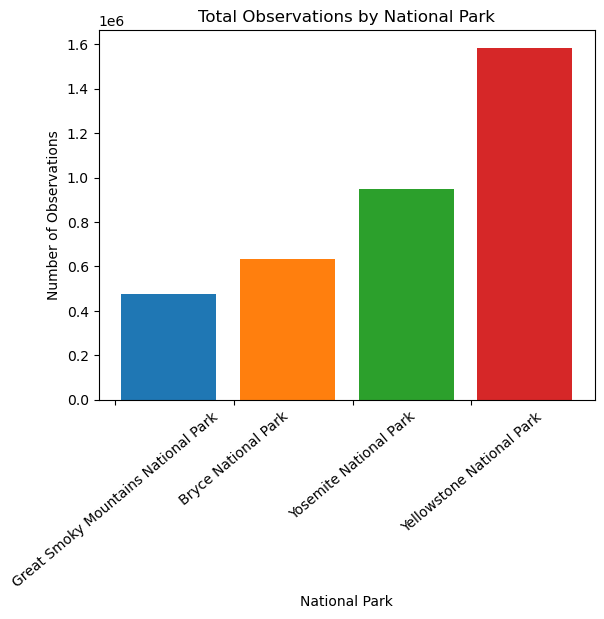

<Figure size 640x480 with 0 Axes>

In [28]:
x = park_totals.index
height = park_totals

ax = plt.subplot(1,1,1)
plt.bar(x,height,color=colors)
ax.set_xticks(ticks=np.arange(4)-.45,labels=x)
ax.set_xticklabels(x,rotation=40)
plt.title("Total Observations by National Park")
plt.xlabel("National Park")
plt.ylabel("Number of Observations")
plt.show()
plt.clf()

### The most frequent observations occur in Yellowstone National Park. 
Now lets compare the distribution of conservation status with the types of species, to help answer q1.

In [29]:
conservation_category = pd.pivot_table(species_df[species_df['conservation_status'] != 'Healthy'],
                                      values = 'common_names',
                                      index = 'conservation_status',
                                      columns = 'category',
                                      aggfunc = pd.Series.count)

conservation_category

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


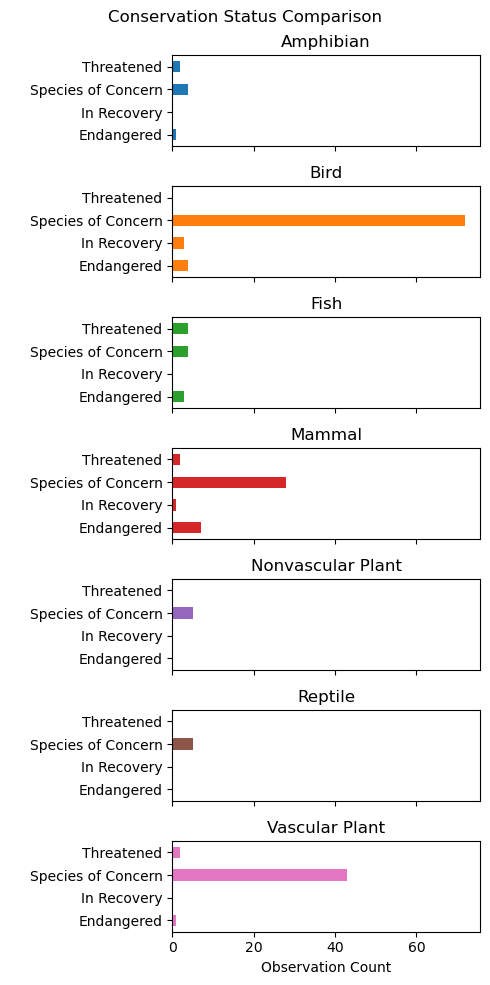

In [30]:
conservation_category.plot(kind = 'barh',
                          subplots=True,
                          xlabel = "Observation Count",
                          title = 'Conservation Status Comparison',
                          ylabel = " ",
                          figsize=(5,10),
                          legend=False)

plt.tight_layout()

### I will now combine conservation_status to compare ALL non-healthy observations by species category.

In [31]:
species_df['protected'] = species_df['conservation_status'] != 'Healthy'

In [32]:
protected = species_df.groupby(['protected','category'])['scientific_name'].count().reset_index().pivot_table(values='scientific_name',
                                                                                                             index='protected',
                                                                                                             columns='category',
                                                                                                             aggfunc='sum')

protected_f = protected.loc[False]
protected_t = protected.loc[True]
protected.index

Index([False, True], dtype='bool', name='protected')

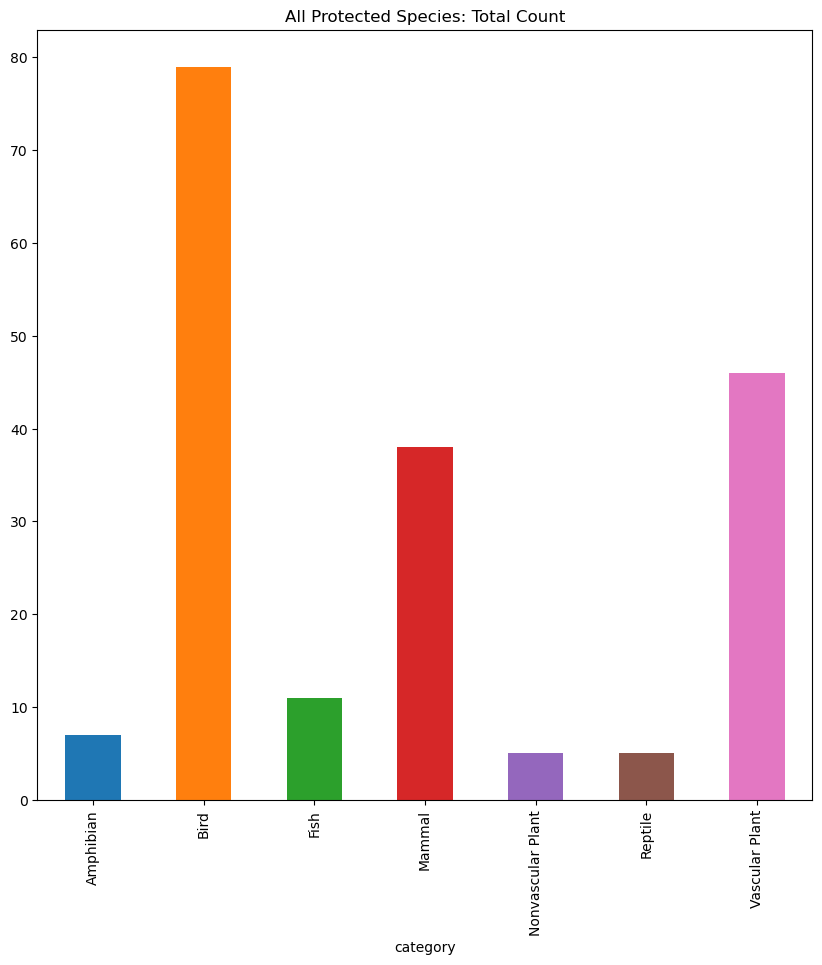

<Figure size 640x480 with 0 Axes>

In [33]:
protected_t.plot(kind = 'bar',
              subplots=False,
                 color=colors,
               figsize=(10,10),
               title="All Protected Species: Total Count")
              
plt.ylabel("")
plt.show()
plt.clf()

**Because this compares absolute values, it will be helpful to also compute the `conservation_status` by percentage for all species.** To compute this, I will first add a column to the species_df called 'protected' which represents if a species has a non-healthy `conservation_status`; this allows me to group all of the healthy and non-healthy species, to compare proprotions. 

In [34]:
protected_T = protected.T
protected_T['ratio'] = (protected_t / (protected_t + protected_f))*100


protected_T

protected,False,True,ratio
category,,,
Amphibian,73,7,8.750000
Bird,442,79,15.163148
Fish,116,11,8.661417
Mammal,176,38,17.757009
Nonvascular Plant,328,5,1.501502
Reptile,74,5,6.329114
Vascular Plant,4424,46,1.029083


## Although Birds have the most absolute protection, they are not the most likely to be protected! 
### Infact, on a proportional basis, Mammals are the most frequently protected at 17%; while Birds are protected 15% of the time.

#### Could this point to a human bias - choosing to protect fellow mammals more than anything else?! Further analysis would need to look at factors contributing to decisions for protecting a species to answer this puzzle!

# Significant Differences across Species?

Now I will investigate the statistical significance of the species `conservation_status`, to help determine if there is a significant association between the species group (mammals, birds, etc.) and their conservation status (protected or not protected).

**To determine statistical significance, I will use the Chi-Square test.** First, I will comput the contingency table as observed, and then expected, using scipy.stats.

In [35]:
from scipy.stats import chi2_contingency

First I will find the p values for  a chi-squared test between mammals and vascular plants.

In [36]:
contingency1 = [[38,176],[46,4424]]

contingency1 = pd.DataFrame(contingency1,columns=['O_Protected','O_Not-Protected'],index=['Mammals','Vascular Plants'])

contingency1

,O_Protected,O_Not-Protected
Mammals,38,176
Vascular Plants,46,4424


### The table above shows the observed ratios, while the table below shows the expected ratios:

In [37]:
chi2, pval, dof, ex = chi2_contingency(contingency1)

ex = pd.DataFrame(ex.round(),columns=['e_Protected','e_Not-Protected'],index=['Mammals','Vascular Plants'])

ex

,e_Protected,e_Not-Protected
Mammals,4.0,210.0
Vascular Plants,80.0,4390.0


In [38]:
pval

1.7349112437604003e-70

The pval is extremely low! This gives me reasons to reject the **null hypothesis** which states there is no statistical significance between `conservation_status` and `category` of species - implying that random chance determines the number of protected observations. 

**The Chi-squared test has helped me determine that atleast for Mammals and Vascular Plants, there is a statistical difference between the observed protection count and the expected; where more mammals were protected than expected!**  
*Might this be confirming my intial theory, that humans protect mammals over all else?!*

# Which Species are Most Common?

Last question I will seek to answer is the most common species observed.

In [39]:
mammals = species_df[species_df.category == "Mammal"].common_names

In [40]:
temp1 = mammals.apply(lambda x: x.lower())\
        .apply(lambda x: x.replace("("," "))\
        .apply(lambda x: x.replace(")"," "))\
        .apply(lambda x: x.replace(","," "))\
        .apply(lambda x: x.replace("-"," "))\
        .apply(lambda x: x.replace("'",""))\
        .str.split()

temp1

0                            [gappers, red, backed, vole]
1                                [american, bison, bison]
2       [aurochs, aurochs, domestic, cattle, feral, do...
3       [domestic, sheep, mouflon, red, sheep, sheep, ...
4                                       [wapiti, or, elk]
                              ...                        
4499                                [mount, lyell, shrew]
4500                                     [montane, shrew]
4501                                        [inyo, shrew]
4502                                 [trowbridges, shrew]
4503                                [broad, footed, mole]
Name: common_names, Length: 214, dtype: object

In [41]:
temp2 = temp1.apply(lambda x: [*set(x)])
                    
temp2

0                           [gappers, red, backed, vole]
1                                      [american, bison]
2       [cattle, feral, aurochs, domestic, domesticated]
3                 [mouflon, feral, red, domestic, sheep]
4                                      [wapiti, elk, or]
                              ...                       
4499                               [lyell, mount, shrew]
4500                                    [montane, shrew]
4501                                       [shrew, inyo]
4502                                [trowbridges, shrew]
4503                               [footed, broad, mole]
Name: common_names, Length: 214, dtype: object

In [42]:
temp3 = temp2.explode()

temp3

0           gappers
0               red
0            backed
0              vole
1          american
           ...     
4502    trowbridges
4502          shrew
4503         footed
4503          broad
4503           mole
Name: common_names, Length: 581, dtype: object

In [43]:
name_count = pd.DataFrame(temp3.value_counts().reset_index())

name_count.head(15)

,index,common_names
0,bat,23
1,shrew,18
2,myotis,17
3,mouse,16
4,tailed,13
5,chipmunk,13
6,american,12
7,squirrel,12
8,vole,11
9,eastern,11


### Bats are the most common type of species observed, followed by Shrew.
Because there are so many bats, I would like to know the vairety: 

In [44]:
bat_variety = pd.DataFrame(species_df.common_names.apply(lambda x: x if ' Bat' in x else "No"))

bat_true = bat_variety[bat_variety.common_names != "No"]

bat_true

,common_names
28,Rafinesque's Big-Eared Bat
29,Big Brown Bat
30,Silver-Haired Bat
31,"Eastern Red Bat, Red Bat"
32,Hoary Bat
36,"Eastern Small-Footed Bat, Eastern Small-Footed..."
37,"Little Brown Bat, Little Brown Myotis"
38,"Northern Long-Eared Bat, Northern Myotis"
39,"Indiana Bat, Indiana Or Social Myotis"
40,Evening Bat


In [45]:
print(f"Check the count to ensure all Bat types where included: {bat_true.shape[0]}")

Check the count to ensure all Bat types where included: 23


# Conclusion

This project was a great reminder to me, just how important planning is at the onset of analysis. Specifically, when the data is outside of domain knowledge, I believe it is valuable to spend time critically thinking from the perspective of the researcher/data collector - there is a reason someone spent time collecting this data, which means they have expectations or hope to use it in some meaningful way. At the onset of the project, I did not spend enough time doing this.

Therefore, as I was half way through the project I found myself discovering new truths about the dataset I originally overlooked; for instace, I did not realize that the conservation_status was dependent on the species, and not the park_name; this makes sense, because if an animal is endangered it is endangered everywhere, and not just in 1 location typically. **But my initial assumption was perhaps an animal could be endangered in 1 park but not the other.** 

The errenous assumption proved to add confusion throughout my initial analysis, and it was not until I circled back to the inital dataset descriptions and research questions, that I realized my understanding was not fully accurate.

In the end, this project - while challenging my abilities as a data analyst - make me excited! Excited to apply the lessons i gained, so that next project I can produce even more insightful and meaningful analysis. I will spend additional time in future projects planning, and really trying to tap into the mindset of the original researcher that spent time collecting the data to begin with. 